In [151]:
import numpy as np 
from matplotlib import pyplot as plt 
from numpy import random as rnd 
import seaborn as sns

## Start by just simulating some place cell data

- Per map, assign cell to have place field w/ x% probability 
    - Start w/ uniform, then allow for reward overreprepresentation
- Poisson or negative binomial noise
- Assuming a fixed, abrupt transition between maps 
- Then use HMM model of hippocampus, w/ remapping fraction correlated w/ probability of being in either map 
    - can just do some kind of unsupervised inference problem? like gaussian hmm 

On trial $i$ for neuron $k$

$$r_{ik} = I_{ik} * \phi_{kZ_{i}}(X_{i}) $$

$$Y_{ik} = Poi(r_{ik}) $$

Where $r =$ firing rate, $I = $ indicator of tuning to context and firing on trial, $\phi = $ neural tuning, $Z = $ context, $X = $ position, $Y = $ observed firing rate,

In [152]:
def simulate_abrupt_remap(n_trials , switch_trial , n_posBins , n_neurons , tau , gain , p_tuned , p_fire , p_remap , visualize = True): 
    """ 
        Simulate place cell remapping that occurs abruptly on trial #switch_trial 
    """
    # define tuning function 
    phi = {}
    phi[0] = rnd.rand(n_neurons) * n_posBins 
    phi[1] = rnd.rand(n_neurons) * n_posBins
    unremapped = rnd.rand(n_neurons) > p_remap
    phi[1][unremapped] = phi[0][unremapped] # neurons with common tuning 
    I = {}
    I[0] = (rnd.rand(n_neurons) < p_tuned).astype(int) # more likely to be non-uniform
    I[1] = (rnd.rand(n_neurons) < p_tuned).astype(int)
    I[1][unremapped] = I[0][unremapped] # neurons with common tuning 
    I_fire = (rnd.rand(n_trials,n_neurons) < p_fire).astype(int)

    # define context
    Z = np.concatenate((np.zeros(switch_trial),np.ones(n_trials - switch_trial)))

    # define weights per trial 
    phi_z = np.concatenate([phi[z][np.newaxis,:] for z in Z])

    # define stimulus - just sweeping over positions
    X = np.linspace(0,n_posBins,n_posBins)
                    
    # Make firing rate and add noise
    r = gain * np.exp(-0.5 * tau * ( np.tile(X[:,np.newaxis],(n_trials,1,n_neurons)) - np.tile(phi_z[:,np.newaxis,:],(1,n_posBins,1)))**2 )
    r[Z == 0,:,:] = r[Z == 0,:,:] * I[0] 
    r[Z == 1,:,:] = r[Z == 1,:,:] * I[1] 
    r = (r.swapaxes(0,1) * I_fire).swapaxes(0,1)
    y = rnd.poisson(r) 

    if visualize == True: 
        # get peaksort for visualization 
        peaks0 = np.argmax(y[Z == 0,:,:].mean(axis = 0),axis = 0)
        peaksort0 = np.argsort(peaks0)
        peaks1 = np.argmax(y[Z == 1,:,:].mean(axis = 0),axis = 0)
        peaksort1 = np.argsort(peaks1)

        # visualize w/ peaksort
        fig , ax = plt.subplots(2,3,figsize = (8,6))
        sns.heatmap(y[0,:,peaksort0].squeeze(),ax = ax[0,0])
        sns.heatmap(y[Z == 0,:,:].mean(axis = 0)[:,peaksort0].T,ax = ax[0,1])
        sns.heatmap(y[Z == 1,:,:].mean(axis = 0)[:,peaksort0].T,ax = ax[0,2])
        sns.heatmap(y[switch_trial,:,peaksort1].squeeze(),ax = ax[1,0])
        sns.heatmap(y[Z == 1,:,:].mean(axis = 0)[:,peaksort1].T,ax = ax[1,1])
        sns.heatmap(y[Z == 0,:,:].mean(axis = 0)[:,peaksort1].T,ax = ax[1,2])
        fig.tight_layout()
    
    # return results 
    results = {"Z" : Z , "y" : y , "I" : I , "unremapped" : unremapped}
    return results


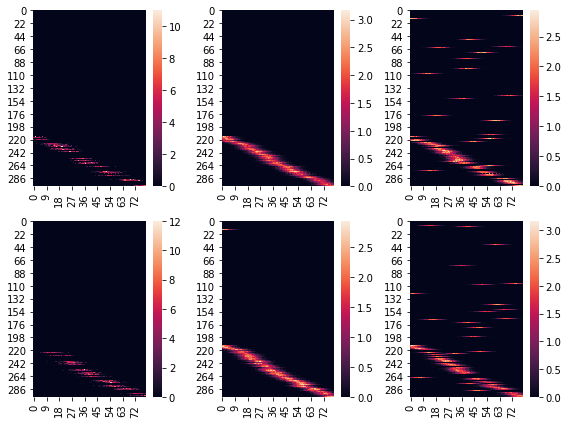

In [153]:
# parameters
n_trials = 120 
switch_trial = 70
n_posBins = 80 
n_neurons = 300
tau = .05
gain = 5
p_tuned = 0.3 # probability of having a place field in a context
p_fire = 0.4 # probability of place field firing on a trial 
p_remap = 0.3 # probability of remapping 

# simulate
results = simulate_abrupt_remap(n_trials , switch_trial , n_posBins , n_neurons , tau , gain , p_tuned , p_fire , p_remap , visualize = True)
fields = ["Z" , "y" , "I","unremapped"] 
Z , y , I , unremapped = [results[field] for field in fields]

## Let's see what the kmeans approach does

In [154]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix 
from scipy.stats import mode
from sklearn.metrics import adjusted_rand_score,accuracy_score

In [155]:
# first look at network similarity
corr = np.zeros((n_trials,n_trials))
for i_trial in range(n_trials): 
    for j_trial in range(n_trials): 
        corr[i_trial,j_trial] = np.corrcoef(y[i_trial,:,:].flatten(),y[j_trial,:,:].flatten())[0,1]

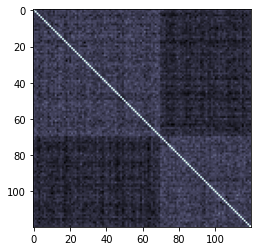

In [156]:
# network similarity 
plt.imshow(corr,cmap = 'bone')

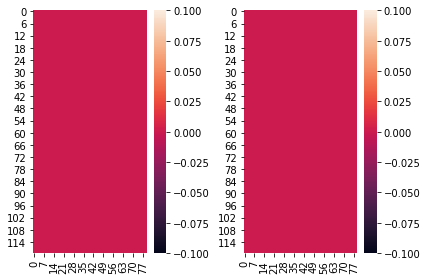

In [157]:
# fit kmeans
model = KMeans(2)
context_hat = model.fit_predict(y.reshape(n_trials,n_posBins * n_neurons))
y_hat = np.concatenate([model.cluster_centers_.reshape(2,n_posBins,n_neurons)[z,:,:][np.newaxis,:,:] for z in context_hat])

# visualize dimensionality reduction 
k_neuron = 78
fig, ax = plt.subplots(1,2)
sns.heatmap(y[:,:,k_neuron],ax = ax[0])
sns.heatmap(y_hat[:,:,k_neuron],ax = ax[1])
fig.tight_layout()


1.0

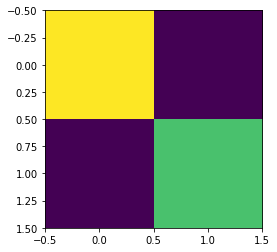

In [158]:
reordering_mapper = {z : mode(Z.flatten()[context_hat == z])[0][0] for z in range(2)}
context_hat_adj = np.array([reordering_mapper[z_hat] for z_hat in context_hat])

plt.imshow(confusion_matrix(Z,context_hat_adj))
accuracy_score(Z , context_hat_adj)


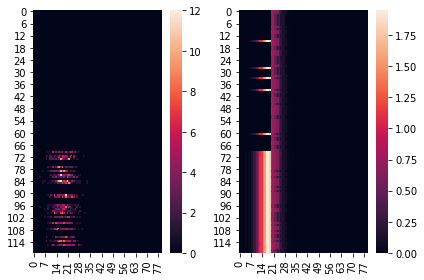

In [159]:
## Alternatively: try to divide into finer clustering to get within trial estimate of remapping timing
n_trackPhases = 4
trackPhase_edges = np.concatenate((np.arange(n_posBins, n_trackPhases,n_posBins / n_trackPhases),[n_posBins]))
trackPhase_masks = [(np.arange(n_posBins) > phaseStart) & (np.arange(n_posBins) > phaseEnd) for phaseStart,phaseEnd in zip(trackPhase_edges[:-1],trackPhase_edges[1:])]

model = KMeans(2 * n_trackPhases)
context_hat = model.fit_predict(y.reshape(n_trials * n_trackPhases,int(n_posBins * n_neurons / n_trackPhases)))

# reconstruct 
cluster_centers_reshape = model.cluster_centers_.reshape(2 * n_trackPhases , int(n_posBins / n_trackPhases),n_neurons)
context_hat_reshape = context_hat.reshape(n_trials,n_trackPhases)
y_hat = np.concatenate([np.concatenate([cluster_centers_reshape[z_i,:,:][np.newaxis,:,:] for z_i in context_hat_reshape[i_trial,:]],axis = 1) for i_trial in range(n_trials)])

# visualize dimensionality reduction 
remap_neurons = np.where((unremapped == 0) & ((I[0] > 0) | (I[1] > 0)))[0]
k_neuron = remap_neurons[0]
fig, ax = plt.subplots(1,2)
sns.heatmap(y[:,:,k_neuron],ax = ax[0])
sns.heatmap(y_hat[:,:,k_neuron],ax = ax[1])
fig.tight_layout()

TypeError: heatmap() missing 1 required positional argument: 'data'

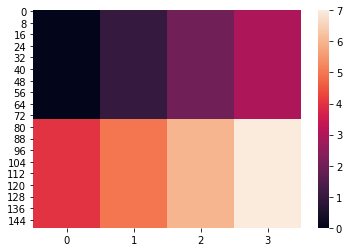

In [160]:
sns.heatmap(z_phases)
sns.heatmap()

0.9520833333333333


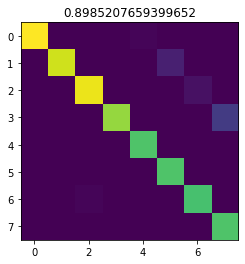

In [ ]:
# put true contexts in an easier format to deal with 
z_phases = np.concatenate((np.tile(np.arange(n_trackPhases),(switch_trial,1)),np.tile(np.arange(n_trackPhases,2 * n_trackPhases),(n_trials - switch_trial,1)))) # .flatten()

# adjust for random ordering of clusters 
reordering_mapper = {z : mode(z_phases.flatten()[context_hat == z])[0][0] for z in range(2 * n_trackPhases)}
context_hat_adj = np.array([reordering_mapper[z_hat] for z_hat in context_hat])

# show confusion mat 
plt.imshow(confusion_matrix(z_phases.flatten(),context_hat_adj)) # ok, so we get a bit worse
plt.title(adjusted_rand_score(z_phases.flatten(),context_hat_adj))
print(accuracy_score(z_phases.flatten(),context_hat_adj))

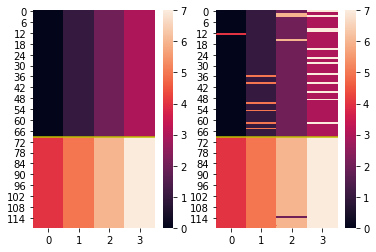

In [ ]:
fig,ax = plt.subplots(1,2)
sns.heatmap(z_phases.reshape(n_trials, 4),ax = ax[0])
ax[0].hlines(switch_trial,0,n_trackPhases,color = 'y')
sns.heatmap(context_hat_adj.reshape(n_trials, 4),ax = ax[1])
ax[1].hlines(switch_trial,0,n_trackPhases,color = 'y')

## Analyze performance over range of values

In [ ]:
np.linspace(.1,.4,5)

array([0.1  , 0.175, 0.25 , 0.325, 0.4  ])

In [189]:
import progressbar
# parameters
n_trials = 150 
switch_trial = 75
n_posBins = 80 
n_neurons = 200
tau = .05
gain = 5
n_trackPhases = 4

# sweep parameters
n_repeats = 2
p_tuned = np.linspace(.1,.4,5) # probability of having a place field in a context
p_fire = np.linspace(.1,.4,5) # probability of place field firing on a trial 
p_remap = np.linspace(0,.5,5) # probability of remapping 

# prep results data structures
accuracy = np.nan + np.zeros((len(p_tuned) , len(p_fire) , len(p_remap) , n_repeats))
ari = np.nan + np.zeros((len(p_tuned) , len(p_fire) , len(p_remap) , n_repeats))
switchTrial_estim = np.nan + np.zeros((len(p_tuned) , len(p_fire) , len(p_remap) , n_repeats))
confusion_mats = np.nan + np.zeros((len(p_tuned) , len(p_fire) , len(p_remap) , n_repeats , 2 , 2))
# finecourse decoding
accuracy_trackPhases = np.nan + np.zeros((len(p_tuned) , len(p_fire) , len(p_remap) , n_repeats))
ari_trackPhases = np.nan + np.zeros((len(p_tuned) , len(p_fire) , len(p_remap) , n_repeats))
confusion_mats_trackPhases = np.nan + np.zeros((len(p_tuned) , len(p_fire) , len(p_remap) , n_repeats , 2 * n_trackPhases , 2 * n_trackPhases))
switchTrial_estim_trackPhases = np.nan + np.zeros((len(p_tuned) , len(p_fire) , len(p_remap) , n_repeats))

# simulate
for i , this_p_tuned in enumerate(p_tuned): 
    for j , this_p_fire in enumerate(p_fire): 
        for k , this_p_remap in enumerate(p_remap): 
            for r in range(n_repeats): 
                results = simulate_abrupt_remap(n_trials , switch_trial , n_posBins , n_neurons , tau , gain , this_p_tuned , this_p_fire , this_p_remap , visualize = False)
                fields = ["Z" , "y" , "I","unremapped"] 
                Z , y , I , unremapped = [results[field] for field in fields]

                # fit kmeans w/ 2 clusters
                model = KMeans(2)
                context_hat = model.fit_predict(y.reshape(n_trials,n_posBins * n_neurons))
                # reformat for scoring
                reordering_mapper = {z : mode(Z.flatten()[context_hat == z])[0][0] for z in range(2)}
                context_hat_adj = np.array([reordering_mapper[z_hat] for z_hat in context_hat])
                # assess performance
                if len(np.where(context_hat_adj == 1)[0]) > 0: # possible for no dual-map detection
                    switchTrial_estim[i, j , k , r] = np.where(context_hat_adj == 1)[0][0]
                accuracy[i , j , k , r] = accuracy_score(Z , context_hat_adj)
                ari[i , j , k , r] = adjusted_rand_score(Z , context_hat_adj)
                confusion_mats[i , j , k , r , :, :] = confusion_matrix(Z,context_hat_adj)

                # # fit kmeans, dividing up track into n_trackPhases
                # trackPhase_edges = np.concatenate((np.arange(n_posBins, n_trackPhases,n_posBins / n_trackPhases),[n_posBins]))
                # trackPhase_masks = [(np.arange(n_posBins) > phaseStart) & (np.arange(n_posBins) > phaseEnd) for phaseStart,phaseEnd in zip(trackPhase_edges[:-1],trackPhase_edges[1:])]
                # model = KMeans(2 * n_trackPhases)
                # context_hat = model.fit_predict(y.reshape(n_trials * n_trackPhases,int(n_posBins * n_neurons / n_trackPhases)))
                # # put true contexts in an easier format to deal with 
                # z_phases = np.concatenate((np.tile(np.arange(n_trackPhases),(switch_trial,1)),np.tile(np.arange(n_trackPhases,2 * n_trackPhases),(n_trials - switch_trial,1)))) # .flatten()
                # # adjust for random ordering of clusters 
                # reordering_mapper = {z : mode(z_phases.flatten()[context_hat == z])[0][0] for z in range(2 * n_trackPhases)}
                # context_hat_adj = np.array([reordering_mapper[z_hat] for z_hat in context_hat])
                # # assess performance
                # accuracy_trackPhases[i , j , k , r] = accuracy_score(z_phases.flatten() , context_hat_adj)
                # ari_trackPhases[i , j , k , r] = adjusted_rand_score(z_phases.flatten() , context_hat_adj)
                # confusion_mats_trackPhases[i , j , k , r , :, :] = confusion_matrix(z_phases.flatten(),context_hat_adj)
    print("%f done"%this_p_tuned)


0.100000 done
0.175000 done
0.250000 done
0.325000 done
0.400000 done


In [194]:
np.abs(switchTrial_estim - switch_trial).shape

(5, 5, 5, 2)

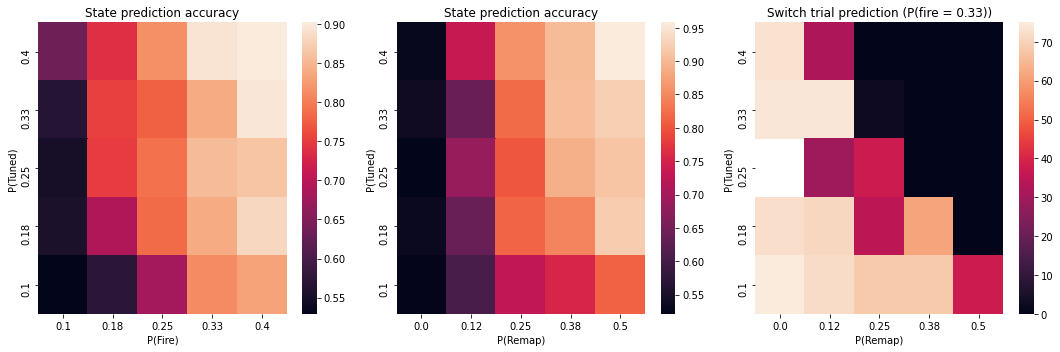

In [203]:
fig , ax = plt.subplots(1,3,figsize = (15,5))
sns.heatmap(np.flipud(accuracy.mean(axis = 3).mean(axis = 2)) , ax = ax[0])
ax[0].set_xticklabels(np.round(p_fire,2))
ax[0].set_yticklabels(np.round(p_tuned,2)[::-1])
ax[0].set_xlabel("P(Fire)")
ax[0].set_ylabel("P(Tuned)")
ax[0].set_title("State prediction accuracy")

sns.heatmap(np.flipud(accuracy.mean(axis = 3).mean(axis = 1)) , ax = ax[1])
ax[1].set_xticklabels(np.round(p_remap,2))
ax[1].set_yticklabels(np.round(p_tuned,2)[::-1])
ax[1].set_xlabel("P(Remap)")
ax[1].set_ylabel("P(Tuned)")
ax[1].set_title("State prediction accuracy")

p_fire_ix = 3
switch_trial_ae = np.abs(switchTrial_estim - switch_trial)
sns.heatmap(np.flipud(switch_trial_ae.mean(axis = 3)[:,3,:]) , ax = ax[2],vmin = 0)
ax[2].set_xticklabels(np.round(p_remap,2))
ax[2].set_yticklabels(np.round(p_tuned,2)[::-1])
ax[2].set_xlabel("P(Remap)")
ax[2].set_ylabel("P(Tuned)")
ax[2].set_title("Switch trial prediction (P(fire = %.2f))"%p_fire[p_fire_ix])
fig.tight_layout()

## Ok, let's look at what happens when we make remapping dependent on something like dirichlet process / HMM inference